# Titanic Dataset

- [link 1](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial)
- [link 2](https://www.kaggle.com/learn-guide/kaggle-competitions)

## Overview

The data has been split into two groups:
- training set (train.csv)
- test set (test.csv)

The *training set* should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The *test set* should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include *gender_submission.csv*, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

## Data Dictionary
| Variable | Definition                                 | Key                                            |
|----------|--------------------------------------------|------------------------------------------------|
| survival | Survival                                   | 0 = No, 1 = Yes                                |
| pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| sibsp    | # of siblings / spouses aboard the Titanic |                                                |
| parch    | # of parents / children aboard the Titanic |                                                |
| ticket   | Ticket number                              |                                                |
| fare     | Passenger fare                             |                                                |
| cabin    | Cabin number                               |                                                |
| embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes
- pclass: A proxy for socio-economic status (SES)
	- 1st = Upper
	- 2nd = Middle
	- 3rd = Lower
- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- sibsp: The dataset defines family relations in this way...
	- Sibling = brother, sister, stepbrother, stepsister
	- Spouse = husband, wife (mistresses and fiancés were ignored)
- parch: The dataset defines family relations in this way...
	- Parent = mother, father
	- Child = daughter, son, stepdaughter, stepson
	- Some children travelled only with a nanny, therefore parch=0 for them

In [19]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings

In [20]:
# load the data

df_train = pd.read_csv('datasets/titanic/train.csv')
df_test = pd.read_csv('datasets/titanic/test.csv')

In [21]:
def concat_df(train_data, test_data):
	# returns a concatenated df of training and test set
	return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
	# returns divided dfs of training and test set
	return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_all = concat_df(df_train, df_test)
df_all.name = 'All Set'

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [24]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## Exploratory Data Analysis

In [19]:
women = df_train.loc[df_train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("Number of women who survived:", rate_women)

Number of women who survived: 0.7420382165605095


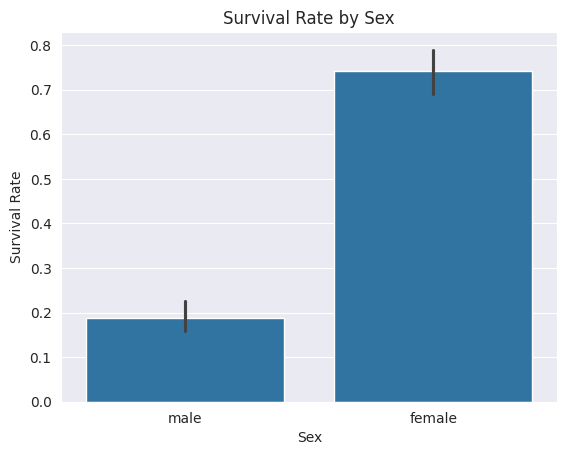

In [25]:
sns.barplot(x='Sex', y='Survived', data=df_train)

# Adding labels and title
plt.title('Survival Rate by Sex')
plt.xlabel('Sex')
plt.ylabel('Survival Rate')

# Display the plot
plt.show()

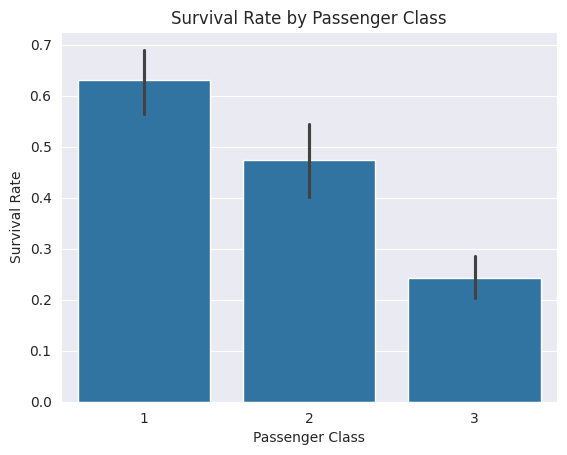

In [26]:
sns.barplot(x='Pclass', y='Survived', data=df_train)

plt.title('Survival Rate by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')

plt.show()

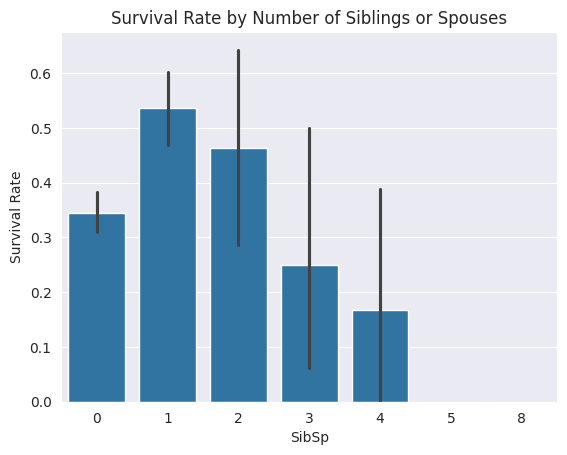

In [37]:
sns.barplot(x='SibSp', y='Survived', data=df_train)

plt.title('Survival Rate by Number of Siblings or Spouses')
plt.xlabel('SibSp')
plt.ylabel('Survival Rate')

plt.show()

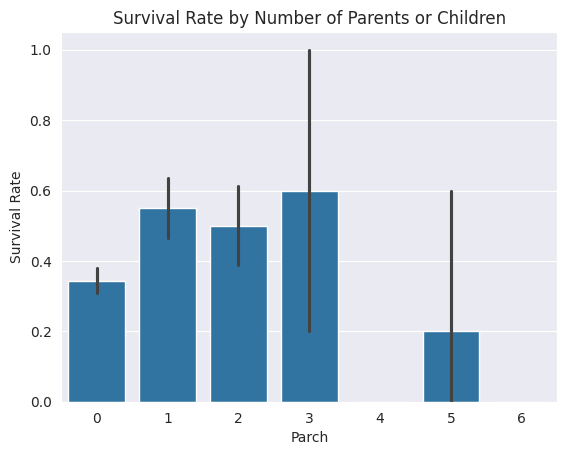

In [36]:
sns.barplot(x='Parch', y='Survived', data=df_train)

plt.title('Survival Rate by Number of Parents or Children')
plt.xlabel('Parch')
plt.ylabel('Survival Rate')

plt.show()

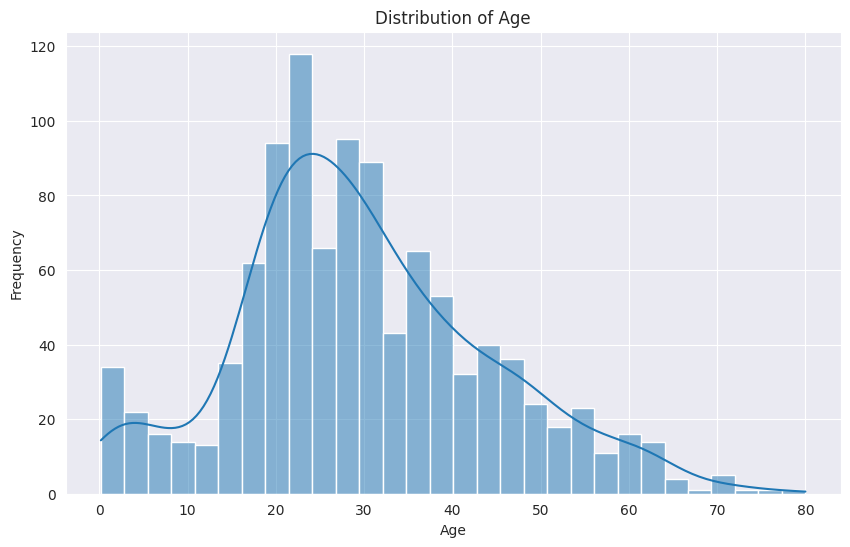

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(df_all['Age'].dropna(), bins=30, kde=True)  # kde=True adds the Kernel Density Estimate

plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.show()

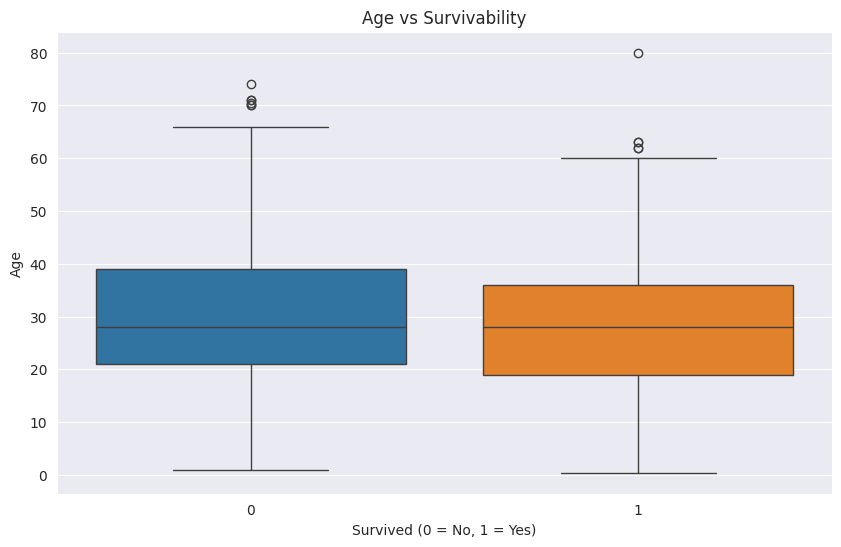

In [35]:
plt.figure(figsize=(10,6))
sns.boxplot(x='Survived', y='Age', data=df_train, hue='Survived')

plt.title('Age vs Survivability')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Age')

plt.legend([],[], frameon=False) # Disable the legend if you prefer

plt.show()

In [38]:
# Convert sex to binary value
df_all['Sex'] = df_all['Sex'].map({'male': 0, 'female': 1})

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,0,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,1,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,1,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,1,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,0,0,0.0,373450


In [ ]:
# one hot embark


### Mini Model With Random Forest

In [4]:
df_train.name = 'Training Set'
df_test.name = 'Test Set'

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}\n'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [9]:
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
624,625,0,3,"Bowen, Mr. David John ""Dai""",male,21.0,0,0,54636,16.1000,NaN,S
551,552,0,2,"Sharp, Mr. Percival James R",male,27.0,0,0,244358,26.0000,NaN,S
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C


### Check for Missing Data

In [18]:
def display_missing(df):
	for col in df.columns.tolist():
		print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
	print('\n')

for df in dfs:
	print('{}'.format(df.name))
	display_missing(df)

print('-'*80)
# calculate the percentage of missing values in each column of a DataFrame
def missing_percentage(df):
	total = df.isnull().sum().sort_values(ascending=False)
	percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
	missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
	return missing_data

for df in dfs:
	print('{}'.format(df.name))
	print(missing_percentage(df))

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0


--------------------------------------------------------------------------------
Training Set
             Total   Percent
Cabin          687  0.771044
Age            177  0.198653
Embarked         2  0.002245
PassengerId      0  0.000000
Su

In [7]:
df_all['Age'] = pd.to_numeric(df_all['Age'], errors='coerce')
df_all['Pclass'] = pd.to_numeric(df_all['Pclass'], errors='coerce')

In [8]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass'])['Age'].median()

In [9]:
for pclass in range(1, 4):
	for sex in ['female', 'male']:
		print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


In [10]:
# filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [11]:
df_all[df_all['Embarked'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


In [12]:
# The missing woman is Mrs. George Nelson Jr. (Martha Evelyn), she travelled with her maid Miss Amelie Icard. They embarked on 28th March 1912 in Southampton. Both of them survived. (https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html)

df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [14]:
df_all[df_all['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


In [15]:
# There is only one passenger with missing Fare value. We can assume that Fare is related to family size (Parch and SibSp) and Pclass features. Median Fare value of a male with a third class ticket and no family is a logical choice to fill the missing value.
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)